In [1]:
# Disable TensorFlow debugging info and warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 2: Info and warnings not displayed 

In [39]:
import tensorflow as tf
import numpy as np
import skimage.io
import sklearn.decomposition
import matplotlib.pyplot as plt
import pathlib
import tqdm
import pickle
import annotation, misc, hyspec_cnn, hyspec_io

In [3]:
# Disable GPUs
tf.config.set_visible_devices([], 'GPU')
visible_devices = tf.config.get_visible_devices()
for device in visible_devices:
    assert device.device_type != 'GPU'
print(tf.version.VERSION)

2.9.1


In [4]:
# Parameters
samples_frac = 0.20

In [46]:
# Paths
json_spectra = pathlib.Path('/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/4c_Rad_Georef_SGC_Spectra/spectra_classes.json')
spectra_dir = pathlib.Path('/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/4c_Rad_Georef_SGC_Spectra')
pca_data_model_file = pathlib.Path('/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/M_PCA_Model/20210825_OlbergAreaA_PCA_data_and_model.npz')


In [6]:
# Read class names and labels 
class_dict = annotation.read_class_dict(str(json_spectra))

In [7]:
class_dict

{'Sand': 1,
 'Zostera marina': 2,
 'Zostera marina with turf algae': 3,
 'Rockweed': 4,
 'Other algae': 5,
 'Zostera marina - NGT': 6,
 'Rockweed - NGT': 7,
 'Other algae - NGT': 8}

In [8]:
# Read datasets
dataset_dirs = [path for path in spectra_dir.glob('*') if path.is_dir()]

In [9]:
# Create random number generator
rng = np.random.default_rng()

In [10]:
# Extract random subsets of annotated spectra
spectra_subset_list = []
labels_subset_list = []

for dataset_path in tqdm.tqdm(dataset_dirs):
    # Read dataset
    dataset = tf.data.experimental.load(str(dataset_path))
    spectra,labels = next(dataset.batch(dataset.cardinality()).as_numpy_iterator())
    
    # Create random indices for subset
    n_random_samp = np.int64(samples_frac*spectra.shape[0])
    random_indices = rng.choice(spectra.shape[0],size=n_random_samp,axis=0,replace=False,shuffle=False)
    
    # Extract spectra and labels, and append to lists
    spectra_subset_list.append(spectra[random_indices])
    labels_subset_list.append(labels[random_indices])

100%|████████████████████████████████████████████████████████| 18/18 [00:26<00:00,  1.46s/it]


In [11]:
# Concatenate lists
spectra_subset = np.concatenate(spectra_subset_list)
labels_subset = np.concatenate(labels_subset_list)

In [12]:
# Inspect number of samples per class
for class_name, class_index in class_dict.items():
    print(f'{class_name:35} {np.count_nonzero(labels_subset==class_index)} samples')

Sand                                258506 samples
Zostera marina                      30317 samples
Zostera marina with turf algae      56485 samples
Rockweed                            19857 samples
Other algae                         12915 samples
Zostera marina - NGT                129065 samples
Rockweed - NGT                      120340 samples
Other algae - NGT                   71089 samples


In [13]:
# Merge original classes with NGT classes
classes_to_merge = [['Zostera marina','Zostera marina - NGT'],
                    ['Rockweed','Rockweed - NGT'],
                    ['Other algae', 'Other algae - NGT']]

merged_class_names = ['Zostera marina', 'Rockweed', 'Other algae']
class_dict_merged, labels_subset_merged = annotation.merge_classes_in_label_vector(
    class_dict, labels_subset, classes_to_merge, merged_class_names)

In [14]:
# Inspect number of samples per class after merging
samples_per_class_original = {}
for class_name, class_index in class_dict_merged.items():
    samples_per_class_original[class_name] = np.count_nonzero(labels_subset_merged==class_index)
    print(f'{class_name:35} {samples_per_class_original[class_name]} samples')

Zostera marina                      159382 samples
Rockweed                            140197 samples
Other algae                         84004 samples
Sand                                258506 samples
Zostera marina with turf algae      56485 samples


In [15]:
# Randomly undersample majority classes to create balanced dataset
samples_per_class = min([samp for samp in samples_per_class_original.values()])
spectra_balanced_list = []
labels_balanced_list = []
for class_name, class_index in class_dict_merged.items():
    class_indices = (labels_subset_merged==class_index)    
    random_indices = rng.choice(samples_per_class_original[class_name],samples_per_class,replace=False,shuffle=False)
    spectra_balanced_list.append(spectra_subset[class_indices][random_indices])
    labels_balanced_list.append(labels_subset_merged[class_indices][random_indices])

In [16]:
# Concatenate data
spectra_balanced = np.concatenate(spectra_balanced_list)
labels_balanced = np.concatenate(labels_balanced_list)

In [17]:
# Inspect number of samples per class in balanced dataset
for class_name, class_index in class_dict_merged.items():
    print(f'{class_name:35} {np.count_nonzero(labels_balanced==class_index)} samples')

Zostera marina                      56485 samples
Rockweed                            56485 samples
Other algae                         56485 samples
Sand                                56485 samples
Zostera marina with turf algae      56485 samples


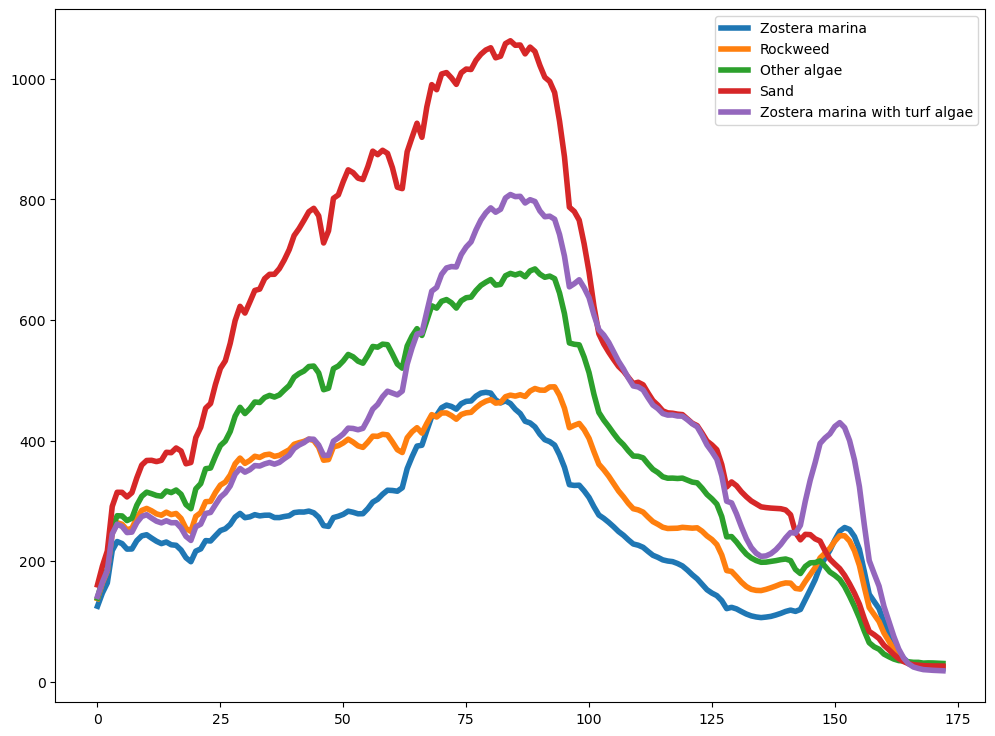

In [18]:
# Plot mean value for each class
plt.figure(figsize=(12,9))
for class_name, class_index in class_dict_merged.items():
    class_mean = np.mean(spectra_balanced[labels_balanced==class_index],axis=0)
    plt.plot(class_mean,label=class_name,linewidth=4)
plt.legend()
plt.show()

In [29]:
# Calculate mean and standard deviation normalize spectra
spectra_mean = np.mean(spectra_balanced,axis=0)
spectra_std = np.std(spectra_balanced,axis=0)
spectra_norm = (spectra_balanced - spectra_mean) / spectra_std

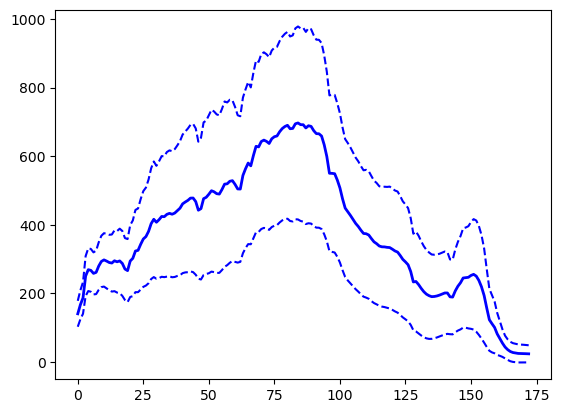

In [29]:
# Plot mean values and standard deviations
plt.plot(spectra_mean,'-b',linewidth=2)
plt.plot(spectra_mean-spectra_std,'--b')
plt.plot(spectra_mean+spectra_std,'--b')
plt.title('Mean values with +/- standard deviations')
plt.show()

In [30]:
# Create preliminary PCA model
pca = sklearn.decomposition.PCA(n_components=30)
_ = pca.fit(spectra_norm)

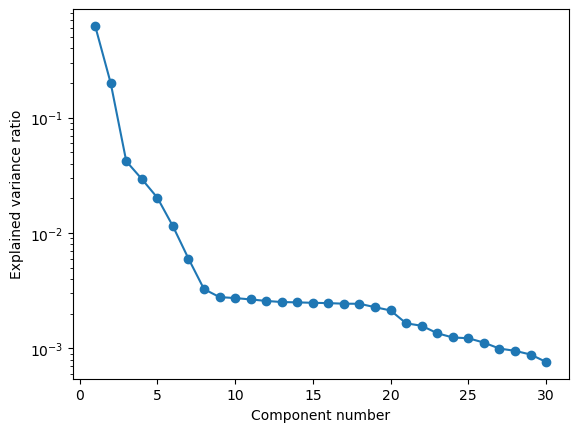

In [31]:
# Plot explained variance ratio
plt.semilogy(np.arange(1,pca.n_components+1),pca.explained_variance_ratio_,'-o')
plt.ylabel('Explained variance ratio')
plt.xlabel('Component number')
plt.show()

In [32]:
print(f'Cumulative explained variance using 8 components: {np.sum(pca.explained_variance_ratio_[0:8])*100} %')

Cumulative explained variance using 8 components: 93.60050510490944 %


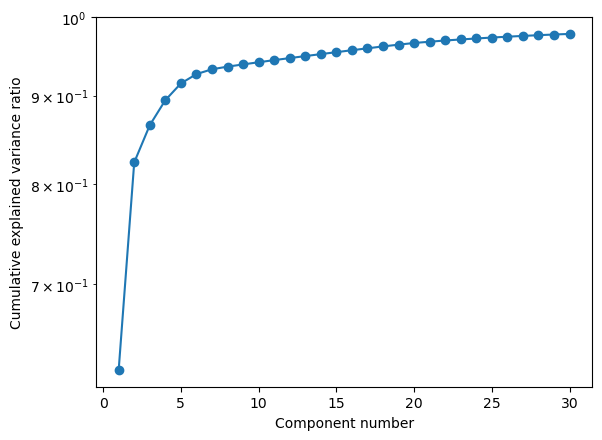

In [33]:
# Plot cumulative explained variance ratio
plt.semilogy(np.arange(1,pca.n_components+1),np.cumsum(pca.explained_variance_ratio_),'-o')
plt.ylabel('Cumulative explained variance ratio')
plt.xlabel('Component number')
plt.show()

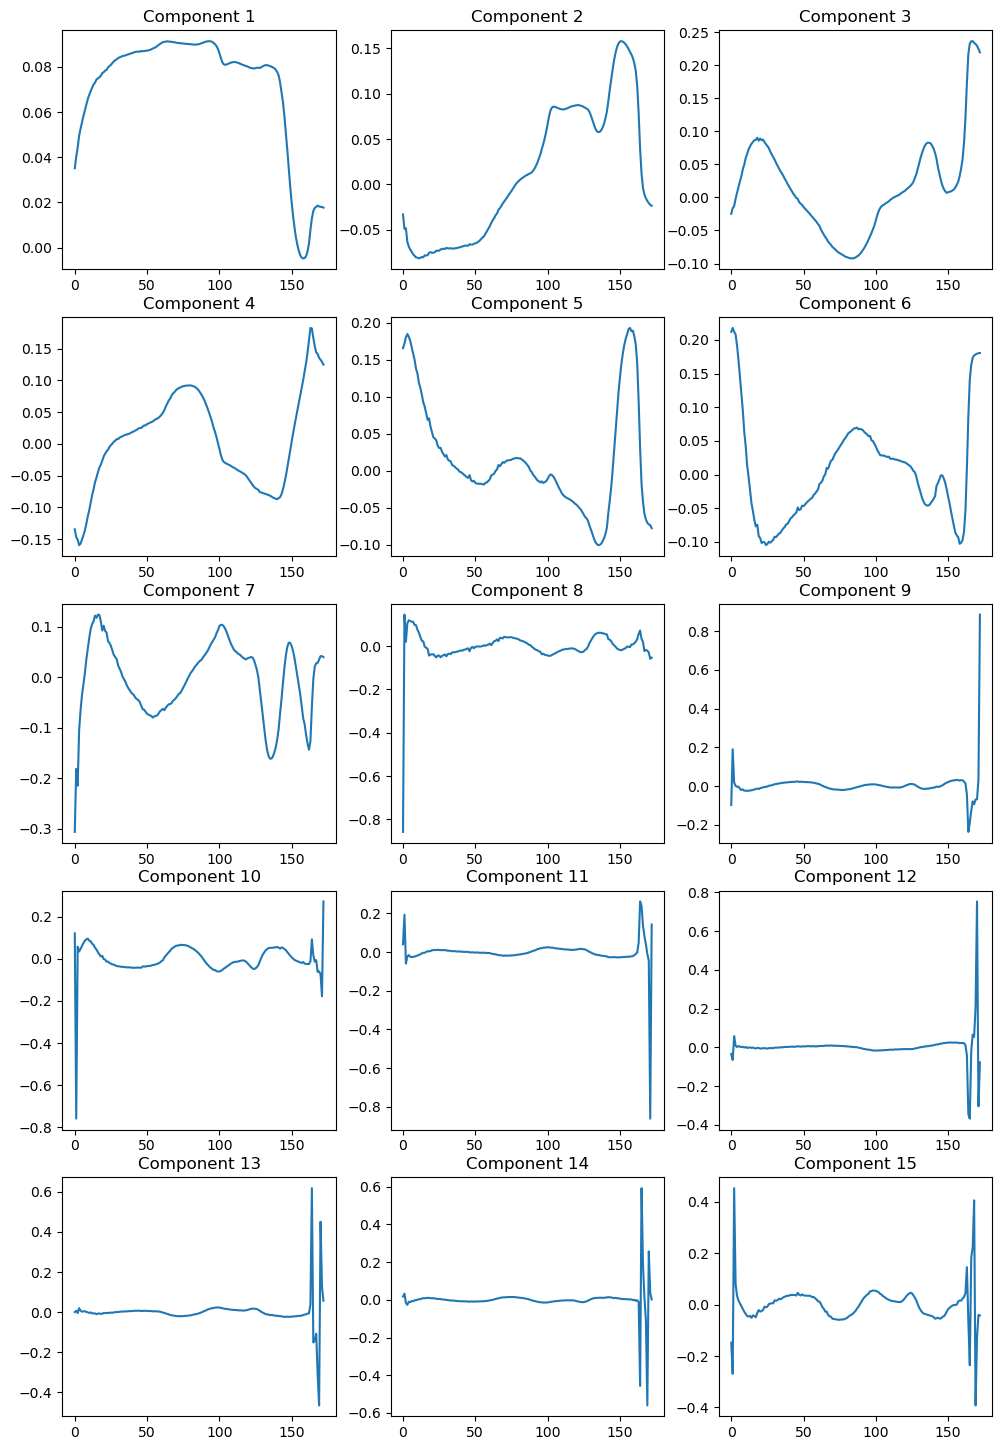

In [34]:
fig, ax = plt.subplots(nrows=5,ncols=3,figsize=(12,18))
for i,component in enumerate(pca.components_[0:15]):
    ax[i//3][i%3].plot(component)
    ax[i//3][i%3].title.set_text(f'Component {i+1}')

In [43]:
# Extract PCA matrix for first components only, and transpose (for later matrix multiplication)
n_comp = 8
pca_components = np.transpose(pca.components_[0:n_comp,:])

In [47]:
# Save to file
np.savez(pca_data_model_file,
         spectra_balanced = spectra_balanced,
         labels_balanced = labels_balanced,
         spectra_mean = spectra_mean,
         spectra_std = spectra_std,
         pca_components = pca_components)

In [59]:
data = {}
with np.load(pca_data_model_file) as npz_files:
    print('Found the following Numpy arrays in the saved file:')
    for variable_name in npz_files.files:
        print(variable_name)
        data[variable_name] = npz_files[variable_name]

Found the following Numpy arrays in the saved file:
spectra_balanced
labels_balanced
spectra_mean
spectra_std
pca_components
